In [41]:
#DRX Initiate Bucket Analysis
#본 분석은 DRX경기 데이터를 기반으로
#조합 내 Initiate 능력을 수치화하고
#해당 지표가 승률 및 상승기/하락기에
#어떠한 영향을 미치는지 분석하는 것을 목표로 한다.
#상승기/하락기 기준일은 2022-11-06(월즈 챔피언십 우승일)이다.

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

RAW_PATH = "data/reference/drx_2022_2025_0829_split.csv"
CHAMP_PATH = "data/reference/Champion_Final.csv"
CHAMP_INIT_PATH = "data/reference/Champion_initiate.csv"

RAW_PATH_df = pd.read_csv(RAW_PATH)
CHAMP_PATH_df = pd.read_csv(CHAMP_PATH)
CHAMP_INIT_PATH_df = pd.read_csv(CHAMP_INIT_PATH)

RAW_PATH_df.head()

,date,tournament,patch,w_l,side,vs,bans,bans_vs,picks,picks_vs,...,pick_vs_top,pick_vs_jg,pick_vs_mid,pick_vs_bot,pick_vs_sup,player_top,player_jg,player_mid,player_bot,player_sup
0,NaN,KR LCK 2022 Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-12,KR LCK 2022 Spring,12.1,Loss,Blue,Liiv SANDBOX,"Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor","Renekton,Lee Sin,Leona,Jayce,Akali","Graves,Viego,Ryze,Aphelios,Sona","Tryndamere,Xin Zhao,Syndra,Jhin,Yuumi",...,Tryndamere,Xin Zhao,Syndra,Jhin,Yuumi,Kingen,Pyosik,Zeka,Deft,BeryL
2,2022-01-12,KR LCK 2022 Spring,12.1,Loss,Blue,Liiv SANDBOX,"Diana,Caitlyn,Yuumi,Samira,Syndra","Renekton,Lee Sin,Twisted Fate,Viktor,LeBlanc","Graves,Jarvan IV,Ryze,Aphelios,Thresh","Tryndamere,Xin Zhao,Akali,Ezreal,Leona",...,Tryndamere,Xin Zhao,Akali,Ezreal,Leona,Kingen,Pyosik,Zeka,Deft,BeryL
3,2022-01-14,KR LCK 2022 Spring,12.1,Loss,Red,Gen.G,"Tryndamere,Renekton,Yuumi,Jayce,Lissandra","Caitlyn,Twisted Fate,Karma,Akshan,Rakan","Gwen,Xin Zhao,LeBlanc,Aphelios,Nautilus","Graves,Lee Sin,Corki,Ziggs,Leona",...,Graves,Lee Sin,Corki,Ziggs,Leona,Kingen,Pyosik,Zeka,Deft,BeryL
4,2022-01-14,KR LCK 2022 Spring,12.1,Loss,Blue,Gen.G,"Karma,Graves,Twisted Fate,Jarvan IV,Kennen","Yuumi,Renekton,Lee Sin,Akshan,Akali","Gragas,Xin Zhao,Viktor,Caitlyn,Lux","Tryndamere,Viego,Corki,Varus,Thresh",...,Tryndamere,Viego,Corki,Varus,Thresh,Kingen,Pyosik,Zeka,Deft,BeryL


In [42]:
RAW_PATH_df["win"] = RAW_PATH_df["w_l"].map({"Win": 1, "Loss":0})
RAW_PATH_df["win"].value_counts(dropna=False)

# 상승기/하락기 구간 컬럼
RAW_PATH_df["date"] = pd.to_datetime(RAW_PATH_df["date"])
PEAK_DATE = pd.Timestamp("2022-11-06")

RAW_PATH_df["period"] = np.where(
    RAW_PATH_df["date"] <= PEAK_DATE,
    "Peak (<=2022-11-06)",
    "Post-Peak (>=2022-11-07)"
)

RAW_PATH_df["period"].value_counts()


period
Post-Peak (>=2022-11-07)    292
Peak (<=2022-11-06)         131
Name: count, dtype: int64

In [43]:
def make_key(s):
    if pd.isna(s):
        return None
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9]", "", s)
    return s

PICK_COLS = [
    "pick_top", "pick_jg", "pick_mid", "pick_bot", "pick_sup",
    "pick_vs_top", "pick_vs_jg", "pick_vs_mid", "pick_vs_bot", "pick_vs_sup"
]

for c in PICK_COLS:
    RAW_PATH_df[c + "_key"] = RAW_PATH_df[c].apply(make_key)

RAW_PATH_df[[c for c in PICK_COLS[:5]] + [c + "_key" for c in PICK_COLS[:5]]].head(3)

,pick_top,pick_jg,pick_mid,pick_bot,pick_sup,pick_top_key,pick_jg_key,pick_mid_key,pick_bot_key,pick_sup_key
0,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None
1,Graves,Viego,Ryze,Aphelios,Sona,graves,viego,ryze,aphelios,sona
2,Graves,Jarvan IV,Ryze,Aphelios,Thresh,graves,jarvaniv,ryze,aphelios,thresh


In [44]:
CHAMP_INIT_PATH_df["Champion_key"] = CHAMP_INIT_PATH_df["Champion"].apply(
    lambda x: re.sub(r"[^a-z0-9]", "", str(x).lower())
)
CHAMP_INIT_PATH_df["initiate_level"] = CHAMP_INIT_PATH_df["Initiate"].astype(int)
CHAMP_INIT_PATH_df.head()

,Champion,Initiate,Champion_key,initiate_level
0,Aatrox,0,aatrox,0
1,Ahri,1,ahri,1
2,Akali,1,akali,1
3,Akshan,0,akshan,0
4,Alistar,2,alistar,2


In [45]:
# 매핑
init_map = dict(
    zip(CHAMP_INIT_PATH_df["Champion_key"], CHAMP_INIT_PATH_df["initiate_level"])
)

def map_init(champ_key):
    return init_map.get(champ_key, 0)

for pos in ["top", "jg", "mid", "bot", "sup"]:
    RAW_PATH_df[f"init_{pos}"] = RAW_PATH_df[f"pick_{pos}_key"].apply(map_init)

for pos in ["top", "jg", "mid", "bot", "sup"]:
    RAW_PATH_df[f"init_vs_{pos}"] = RAW_PATH_df[f"pick_vs_{pos}_key"].apply(map_init)

In [54]:
# initiate_score 계산
our_cols = [f"init_{p}" for p in ["top", "jg", "mid", "bot", "sup"]]
vs_cols  = [f"init_vs_{p}" for p in ["top", "jg", "mid", "bot", "sup"]]

RAW_PATH_df["initiate_score"] = RAW_PATH_df[our_cols].sum(axis=1)
RAW_PATH_df["initiate_score_vs"] = RAW_PATH_df[vs_cols].sum(axis=1)
RAW_PATH_df["initiate_diff"] = RAW_PATH_df["initiate_score"] - RAW_PATH_df["initiate_score_vs"]

# initiate_score 구간화
def bucket(x):
    if x <= 1:
        return "0-1"
    elif x <= 3:
        return "2-3"
    elif x <= 5:
        return "4-5"
    else:
        return "6+"

RAW_PATH_df["init_bucket"] = RAW_PATH_df["initiate_score"].apply(bucket)

# 버킷별 승률 요약
summary = (
    RAW_PATH_df.groupby("init_bucket")
      .agg(games=("win", "count"), winrate=("win", "mean"))
      .reset_index()
)

# 버킷 정렬
order = ["0-1", "2-3", "4-5", "6+"]

# 전체 버킷 승률 비교
summary = (
    RAW_PATH_df.groupby("init_bucket")
      .agg(games=("win", "count"), winrate=("win", "mean"))
      .reset_index()
)
summary["init_bucket"] = pd.Categorical(summary["init_bucket"], categories=order, ordered=True)
summary = summary.sort_values("init_bucket")

# 상승기/하락기 비교
summary_period = (
    RAW_PATH_df.groupby(["period", "init_bucket"])
      .agg(games=("win", "count"), winrate=("win", "mean"))
      .reset_index()
)
summary_period["init_bucket"] = pd.Categorical(summary_period["init_bucket"], categories=order, ordered=True)
summary_period = summary_period.sort_values(["period", "init_bucket"])

summary_period

,period,init_bucket,games,winrate
0,Peak (<=2022-11-06),0-1,23,0.521739
1,Peak (<=2022-11-06),2-3,58,0.500000
2,Peak (<=2022-11-06),4-5,39,0.692308
3,Peak (<=2022-11-06),6+,11,0.363636
4,Post-Peak (>=2022-11-07),0-1,12,0.250000
5,Post-Peak (>=2022-11-07),2-3,104,0.336538
6,Post-Peak (>=2022-11-07),4-5,115,0.304348
7,Post-Peak (>=2022-11-07),6+,45,0.355556


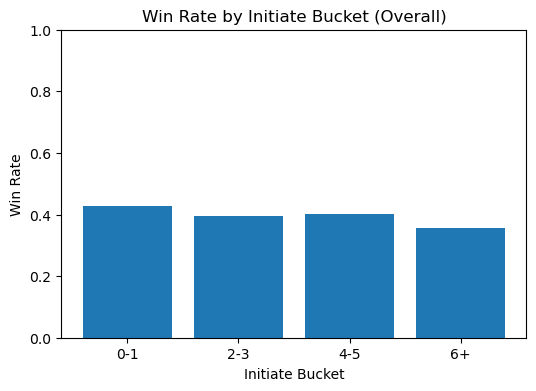

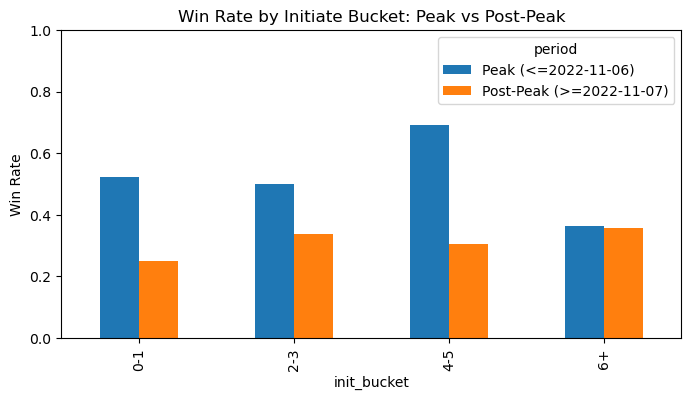

In [55]:
# 시각화
#Initite_score를 구간화하여,
#조합에 따른 전체 승률 분포를 확인한다.
plt.figure(figsize=(6,4))
plt.bar(summary["init_bucket"].astype(str), summary["winrate"])
plt.ylim(0, 1)
plt.title("Win Rate by Initiate Bucket (Overall)")
plt.xlabel("Initiate Bucket")
plt.ylabel("Win Rate")
plt.show()

#DRX의 상승기/하락기 별
#Initiate 구조에 따른 승률 분포를 비교한다.
pivot = summary_period.pivot(index="init_bucket", columns="period", values="winrate")
pivot.plot(kind="bar", figsize=(8,4))
plt.ylim(0, 1)
plt.title("Win Rate by Initiate Bucket: Peak vs Post-Peak")
plt.ylabel("Win Rate")
plt.show()